In [1]:
# Import Built-In libraries
import os
import numpy as np

In [2]:
# Change working directory to ROOT
FILE = os.getcwd()
os.chdir(FILE +"/..")
os.getcwd()

'/mnt/d/microaneurism_detection'

In [139]:
# Built-In libraries
import os
import copy
import itertools

# External libraries
import PIL
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, rgb2hex, BoundaryNorm 
from matplotlib.colorbar import ColorbarBase
from tqdm import tqdm

import pandas as pd
import scipy.cluster.hierarchy as shc
import sklearn
from sklearn.cluster import AgglomerativeClustering


class Fundus():
    def __init__(self, source=False, **kwargs):
        # Constructors
        if isinstance(source, str):
            self.im = self._image_from_file(source)

        if isinstance(source, np.ndarray):
            self.im = self._image_from_pixels(source, **kwargs)

        # Attributes
        self.palette, self.counts = self.get_palette()
        
        # Attributes
        self.cmap = self.get_cmap()

    # Constructors
    @staticmethod
    def _image_from_file(path):
        return Image.open(path, mode="r")

    @staticmethod
    def _image_from_pixels(pixels, **kwargs):
        arr = np.resize(pixels, (kwargs["w"], kwargs["h"], 3)).astype(np.uint8)
        im = Image.fromarray(arr)
        im = im.rotate(90, expand=True)
        im = ImageOps.flip(im)
        return im

    # Get attributes
    def get_palette(self):
        pixels = self.get_pixels()
        return np.unique(pixels, axis=0, return_counts=True)
    
    def get_cmap(self):
        # Transform 0-255 RGB to 0-1 RGB        
        # Create a color map form the provided colors
        return ListedColormap(self.palette/255, N=len(self.palette))

    # Data Transformations
    def as_array(self):
        return np.asarray(self.im)

    def get_channels(self):
        """
        :return np.array [c * x * y] [3 * w * h]
        """
        r, g, b = self.as_array().T
        return r, g, b

    def get_channels_flattened(self):
        """
        Returns per color channel a 1-D array of size  (w * h) with all
        the pixels.

        :return: np.array for R, G, B channels respectively.
        """
        r, g, b = self.get_channels()
        return r.flatten(), g.flatten(), b.flatten()

    def get_pixels(self):
        """
        Returns 2-D array of the RGB pixel values for the whole image.
        size = 3 * (w * h)
        :return: np.array
        """
        return np.array(self.get_channels_flattened()).T

    # VISUALIZATION
    @staticmethod
    def plot_color_bar(colors):
        # Transform 0-255 RGB to 0-1 RGB
        colors = colors/255
        
        # Create a color map form the provided colors
        cmap = ListedColormap(colors)
        
        # Convert the colors to hex
        hex = np.array([rgb2hex(x) for x in colors])

        # Set canvas
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))
        fig.subplots_adjust(bottom=0.25)

        # Calculate bounds
        bounds = range(cmap.N + 1)
        norm = BoundaryNorm(bounds, cmap.N)

        # Plot colorbar
        bar = ColorbarBase(ax=ax,
                           cmap=cmap,
                           norm=norm,
                           boundaries=bounds,
                           extend="neither",
                           ticks=None,
                           ticklocation="top",
                           drawedges=False,
                           spacing="uniform",
                           filled=True,
                           orientation="horizontal")

        bar.set_ticklabels(hex)
    
    def plot_palette(self):
        self.plot_color_bar(np.sort(self.palette, axis=0))

    # MODIFICATION FILTERING
    def mask(self, colors, replacement=(0, 0, 0), inplace=False, reverse=False):
        """
        Replaces a list of pixels for a given value
        :param colors: 2-D array of the RGB pixel values for the image.
        :param replacement: 1-D [0-255] RGB array of the color to replace with
        :return: modified 2-D array
        """
        # Stablish canvas
        if reverse:
            # Black canvas
            pixels = np.zeros(self.get_pixels().shape, dtype=np.uint8)
        else:
            # Original image
            pixels = self.get_pixels()
        
        # Mask pixels
        for c in tqdm(colors):
            if (c == [0, 0, 0]).all():
                continue
            pixels[(self.get_pixels() == c).all(axis=1)] = c if reverse else replacement

        # Output 
        if inplace:
            self.im = self._image_from_pixels(pixels, w=self.im.size[0], h=self.im.size[1])
        else:
            return pixels
 


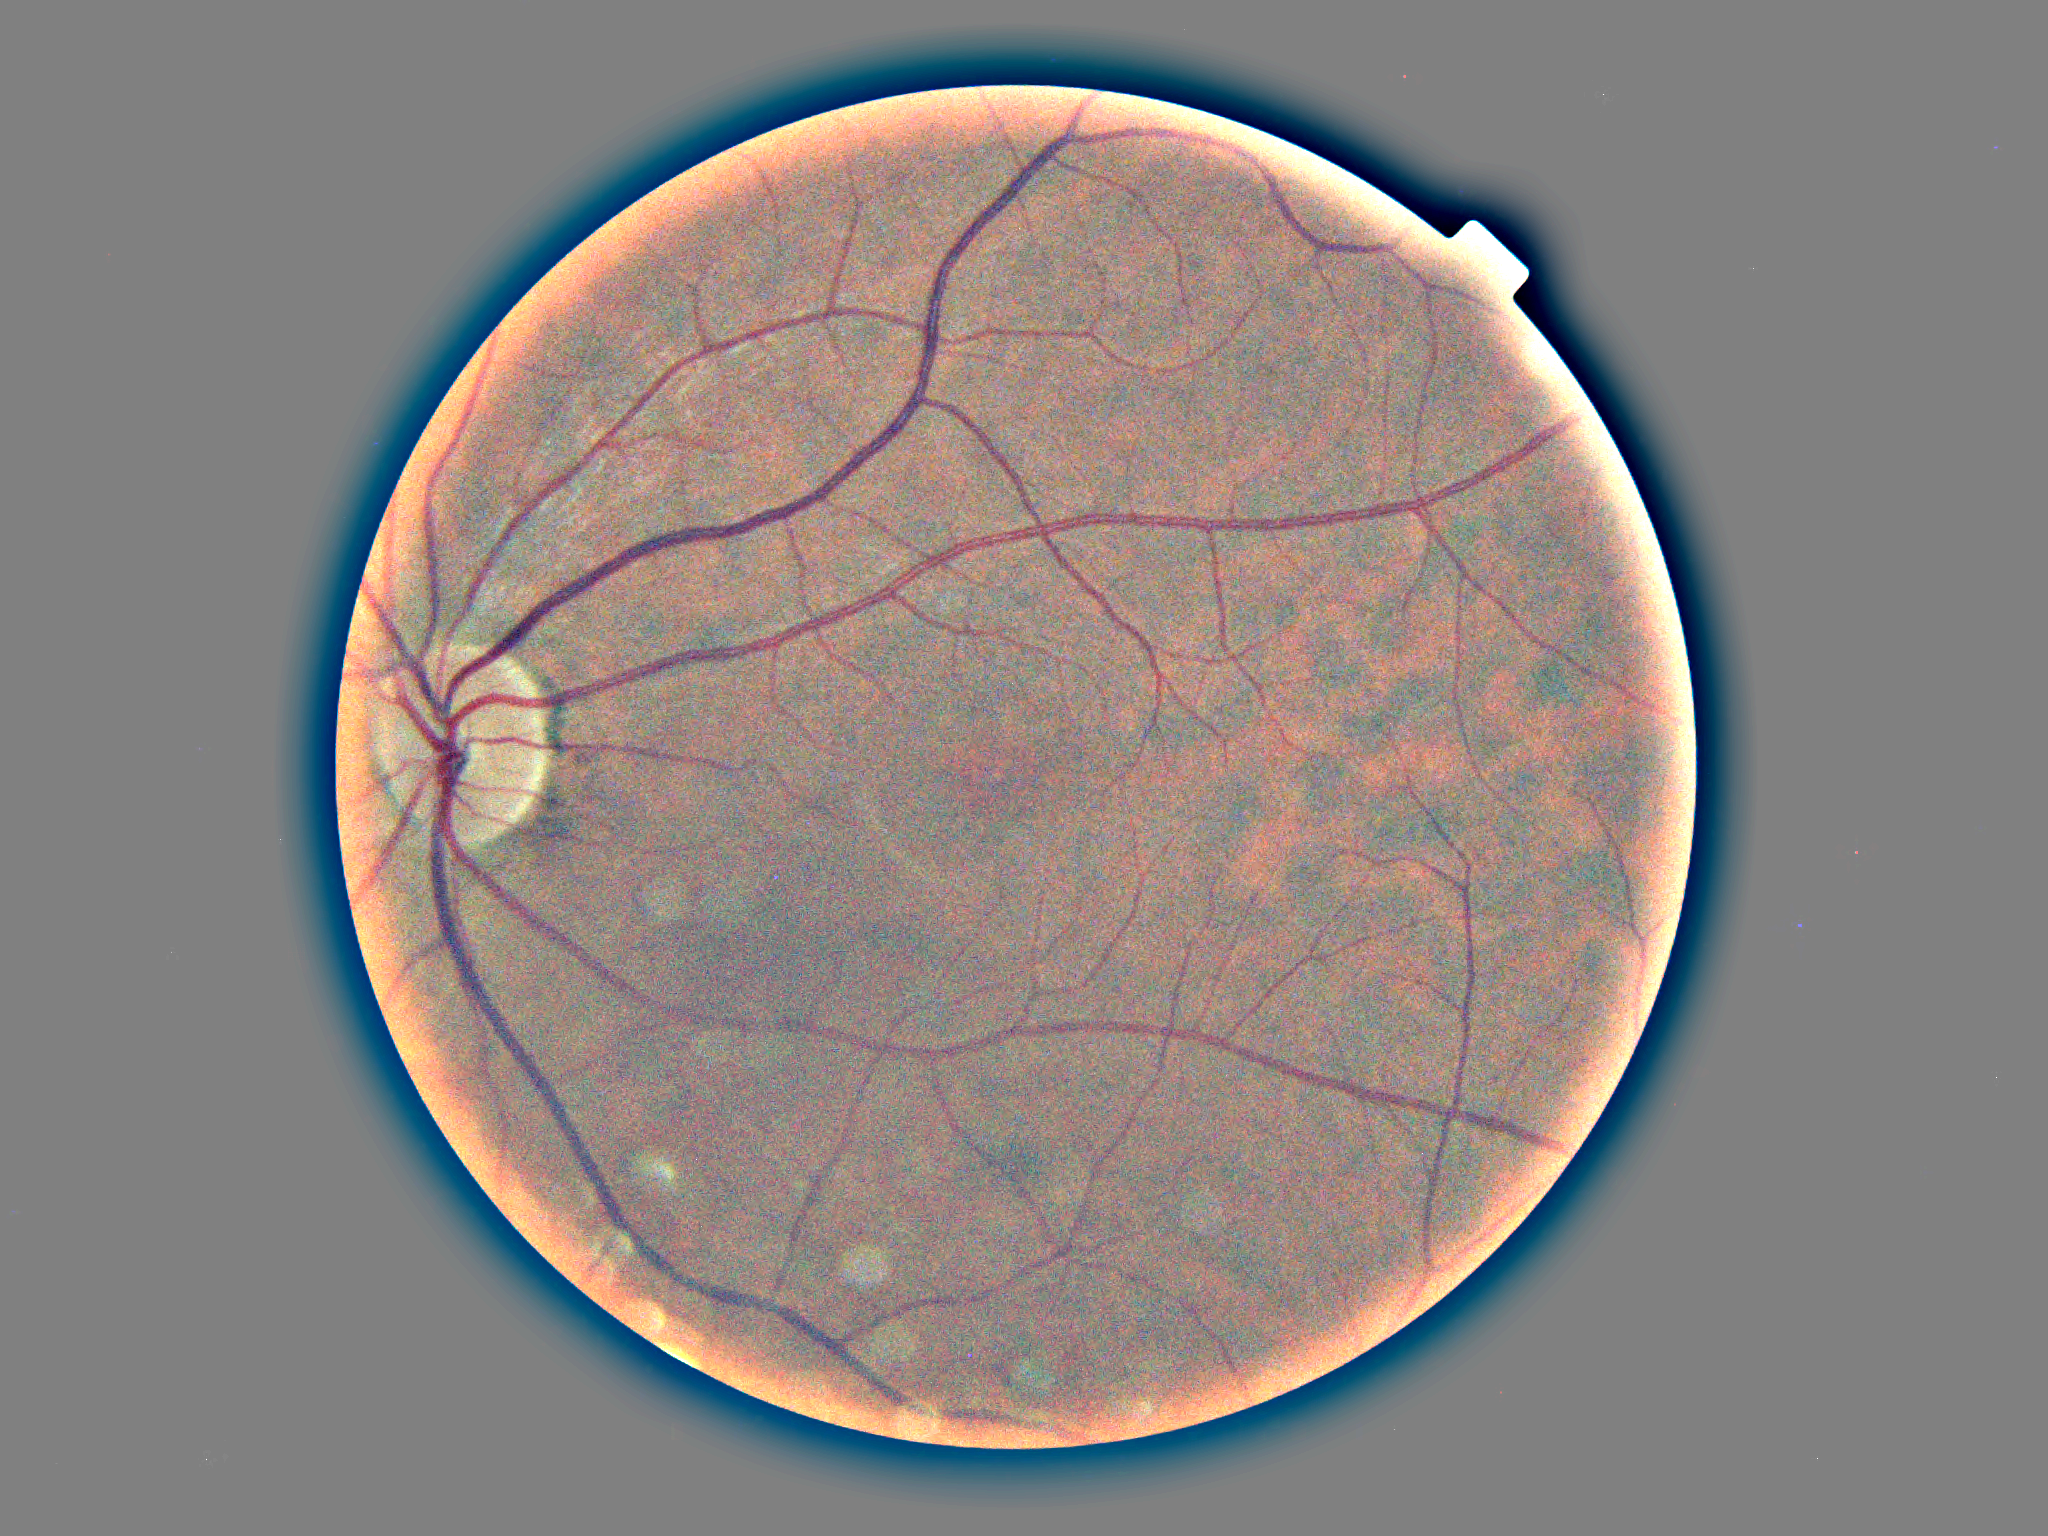

In [140]:
# Read Image, create fundus object
original = Fundus(os.path.abspath("data/noma/male_extra_0.png"))
original.im

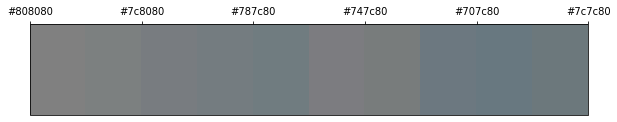

In [141]:
pal_byfrequency = original.palette[np.argsort(original.counts)][::-1]
original.plot_color_bar(pal_byfrequency[:10])

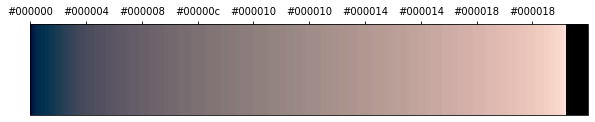

In [142]:
original.plot_palette()

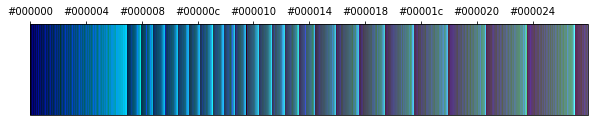

In [143]:
from matplotlib import cm
original.cmap(0.2, bytes=True)
original.plot_color_bar(original.palette[:original.cmap.N//6])

In [ ]:
#original.mask(colors=colors[0:500], inplace=True)
%%time
original.mask(colors=original.palette[:original.cmap.N//6], inplace=True, reverse=True)
original.im

In [ ]:
# Get dendogram at pixel level
plt.figure(figsize=(10, 10))
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(original.palette, method='ward'))

In [ ]:
# Merging 2 closest colors
print(len(original.palette))
cluster = AgglomerativeClustering(n_clusters=len(original.palette)//2, affinity='euclidean', linkage='ward')
clustered = cluster.fit_predict(original.palette)

In [ ]:
from tqdm import tqdm
from multiprocessing import Pool

print (os.cpu_count())

pal = original.palette

pool = Pool(processes=12)
results = [pool.apply(original.reverse_mask, args=(pal[clustered==i], np.mean(pal[clustered==i], axis=0).astype(np.uint8) ,) for i in set(clustered))]

for i in tqdm(set(clustered)):
    colors = original.palette[clustered==i]
    replacement = np.mean(colors, axis=0).astype(np.uint8)
    for c in colors:
        pixels[(original.get_pixels()==c).all(axis=1)] = replacement
        

In [ ]:
new = Fundus(pixels, w=original.im.size[0], h=original.im.size[1])
new.im

In [10]:
from multiprocessing import Pool
#pool = Pool(os.cpu_count())


12


In [11]:
def cube(x):
    return(x**3)

results = [pool.apply(cube, args=(x,)) for x in range(1,7)]
print(results)



[1, 8, 27, 64, 125, 216]
